In [ ]:
!pip install -q transformers

In [ ]:
!pip install onnxruntime

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r drive/MyDrive/yt_comments_sentiment/ft_distilroberta ./
!cp -r drive/MyDrive/yt_comments_sentiment/ft-distilroberta.onnx ./

In [ ]:
# scrape youtube comments:
# https://smartproxy.com/blog/scraping-youtube-comments

In [3]:
!pip install https://github.com/egbertbouman/youtube-comment-downloader/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 10.8 kB 37.6 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 KB 5.9 MB/s eta 0:00:00
  Created wheel for youtube-comment-downloader: filename=youtube_comment_downloader-0.1-py3-none-any.whl size=7651 sha256=4094366f979fcc4c37c704b54ee23c40a9a32135cf6e76c040bf06d94d22e70d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqyc3ww1/wheels/78/be/b7/ccd0c570f1a4589017aaf34fdd461d2c69244e869114c5dfa4
Successfully built youtube-comment-downloader


In [4]:
from itertools import islice
from youtube_comment_downloader import *

def get_yt_data(video_link):
  downloader = YoutubeCommentDownloader()
  comments = downloader.get_comments_from_url(video_link, sort_by=SORT_BY_POPULAR)
  comments_list = []
  votes_list = []
  for comment in islice(comments, 100):
    if '.' not in comment['cid']:
      comments_list.append(comment['text'])
      votes_list.append(comment['votes'])

  return comments_list, votes_list

In [12]:
video_link = 'https://www.youtube.com/watch?v=IsAwsIwdjt8'
comments_list, votes_list = get_yt_data(video_link)

In [14]:
comments_list[0]

"you'd think they'd male a laminated screen on it but they didn't"

In [15]:
comments_list[1]

'Still having to use the first Apple Pencil and then having to use an adapter to charge the pencil feels shoddy, especially for Apple.'

In [16]:
comments_list[2]

"The iPad was always a no brainer tablet. Competitive price, impressive performance, and the App Store. Now Apple made Android tablets ironically more interesting than they have been for a long time. In Europe, the iPad now starts at 579€. That's not a good deal anymore."

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("./ft_distilroberta")

In [40]:
# first create session 
import onnxruntime 
onnx_session = onnxruntime.InferenceSession('ft-distilroberta.onnx', 
                                            providers=['CPUExecutionProvider']
                                            )

In [ ]:
import time
import torch
import numpy as np

len_comments = len(comments_list)
result = []
onnxtime = []
pytorchtime = []

for i in range(0, len_comments, 10):
  
  j = i+10
  if i+10 > len_comments:
    j = len_comments
  
  inputs = tokenizer(comments_list[i:j], max_length=512, padding=True, 
                     truncation=True, return_tensors='pt')
  
  # # ONNX
  # start = time.time()
  # feed = dict(input_ids=np.array(inputs["input_ids"]),
  #           attention_mask=np.array(inputs["attention_mask"]),)
  # onnx_outputs = onnx_session.run(None, feed)
  # end = time.time()

  # onnxtime.append((end-start) * 10**3) #

  # Pytorch
  # start = time.time()
  pytorch_outputs = model(**inputs)
  # end = time.time()
  
  # pytorchtime.append((end-start) * 10**3) #
  
  predictions = torch.nn.functional.softmax(pytorch_outputs.logits, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  result.extend([x for x in np.argmax(predictions, axis=1)])

# print("onnx TOTAL execution time:", sum(onnxtime), "ms")
# print("pytorch TOTAL execution time:", sum(pytorchtime), "ms")

In [42]:
neg_percentage = result.count(0)*100/len_comments
neu_percentage = result.count(1)*100/len_comments
pos_percentage = result.count(2)*100/len_comments
print('NEG %age:', neg_percentage)
print('NEU %age:', neu_percentage)
print('POS %age:', pos_percentage)

NEG %age: 10.0
NEU %age: 25.0
POS %age: 65.0


([<matplotlib.patches.Wedge at 0x7f07b0dd30a0>,
 [Text(1.1412678178182487, 0.3708203985925972, 'Negative'),
  Text(0.18772134695139028, 1.1852260104717394, 'Neutral'),
  Text(-0.5447886697619784, -1.069207793321286, 'Positive')],
 [Text(2.2825356356364974, 0.7416407971851944, '10.0%'),
  Text(0.37544269390278057, 2.3704520209434787, '25.0%'),
  Text(-1.0895773395239567, -2.138415586642572, '65.0%')])

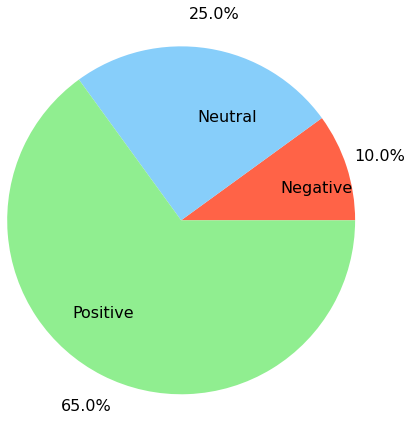

In [43]:
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
sizes = [neg_percentage, neu_percentage, pos_percentage]
colors = ['#FF6347', '#87CEFA', '#90EE90']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
       pctdistance=1.2, labeldistance=.6, 
       textprops={'fontsize': 16}, radius=2, colors = colors)